In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# # 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [66]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
# log1p 변환 수행
df['age'] = df['age'].apply(np.log1p)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,3.761200,2,0.00,1,1,1,101348.88,1
1,608,2,1,3.737670,1,83807.86,1,0,1,112542.58,0
2,502,0,1,3.761200,8,159660.80,3,1,0,113931.57,1
3,699,0,1,3.688879,1,0.00,2,0,0,93826.63,0
4,850,2,1,3.784190,2,125510.82,1,1,1,79084.10,0


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

X = df[features]
y = df['churn']

X = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [69]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada_best_params = {}
ada = AdaBoostClassifier(random_state=42, **ada_best_params)

cat_best_params = {
    'depth': 4, 
    'iterations': 100, 
    'learning_rate': 0.1
}
cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 2.21])
# cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 50])

xgb_best_params = {
'colsample_bytree': 0.998835926756326,
    'learning_rate': 0.05918736154295684,
    'max_depth': 4,
    'min_child_weight': 4,
    'n_estimators': 152,
    'subsample': 0.7171956369176462,
    'scale_pos_weight': 1.9,  # Recall 최적화된 비율
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
xgb = XGBClassifier(random_state=42, **xgb_best_params)

rf_best_params = {
    'n_estimators':200, 
    'max_depth':15, 
    'min_samples_leaf':2, 
    'min_samples_split':5
}
rf = RandomForestClassifier(random_state=42, **rf_best_params, verbose=0)

              precision    recall  f1-score   support

           0     0.8825    0.9435    0.9120      2389
           1     0.6973    0.5090    0.5885       611

    accuracy                         0.8550      3000
   macro avg     0.7899    0.7262    0.7502      3000
weighted avg     0.8448    0.8550    0.8461      3000



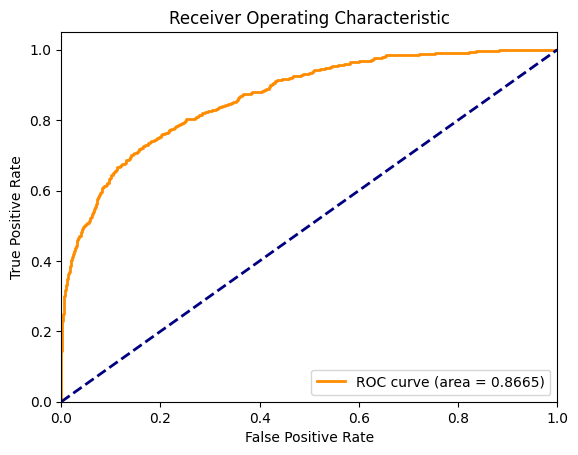

In [70]:
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

estimators = [
    ('cat', cat),
    # ('xgb', xgb),
    ('rf', rf),
    ('ada', ada)
]

voting = VotingClassifier(estimators=estimators, voting='soft')

voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(voting, X_test, y_test)

['cat' 'rf' 'ada']
              precision    recall  f1-score   support

           0     0.9025    0.9067    0.9046      2389
           1     0.6283    0.6170    0.6226       611

    accuracy                         0.8477      3000
   macro avg     0.7654    0.7618    0.7636      3000
weighted avg     0.8467    0.8477    0.8471      3000



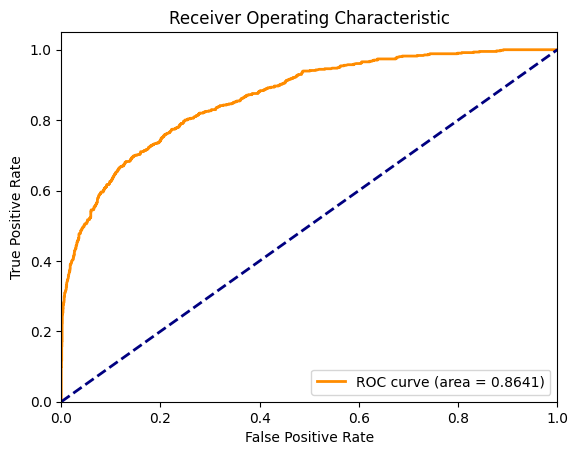

['cat' 'ada' 'rf']
              precision    recall  f1-score   support

           0     0.9011    0.9117    0.9064      2389
           1     0.6381    0.6088    0.6231       611

    accuracy                         0.8500      3000
   macro avg     0.7696    0.7603    0.7647      3000
weighted avg     0.8475    0.8500    0.8487      3000



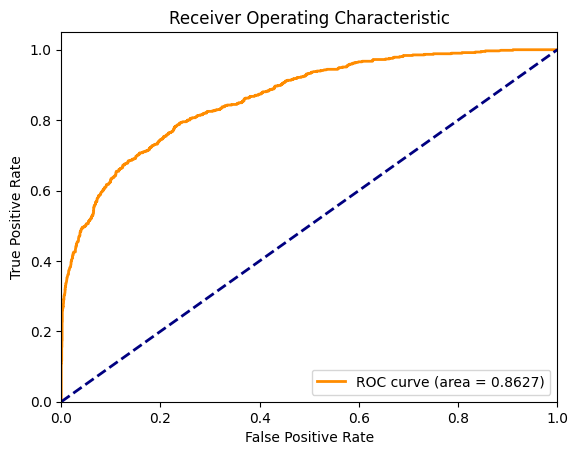

['rf' 'cat' 'ada']
              precision    recall  f1-score   support

           0     0.9038    0.9041    0.9040      2389
           1     0.6246    0.6236    0.6241       611

    accuracy                         0.8470      3000
   macro avg     0.7642    0.7639    0.7640      3000
weighted avg     0.8469    0.8470    0.8470      3000



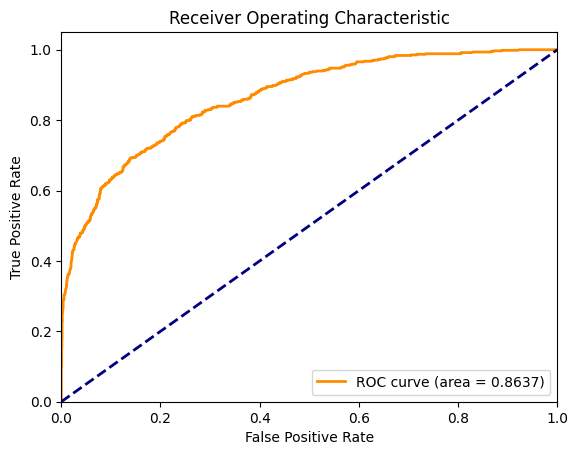

['rf' 'ada' 'cat']
              precision    recall  f1-score   support

           0     0.9030    0.9075    0.9052      2389
           1     0.6311    0.6187    0.6248       611

    accuracy                         0.8487      3000
   macro avg     0.7670    0.7631    0.7650      3000
weighted avg     0.8476    0.8487    0.8481      3000



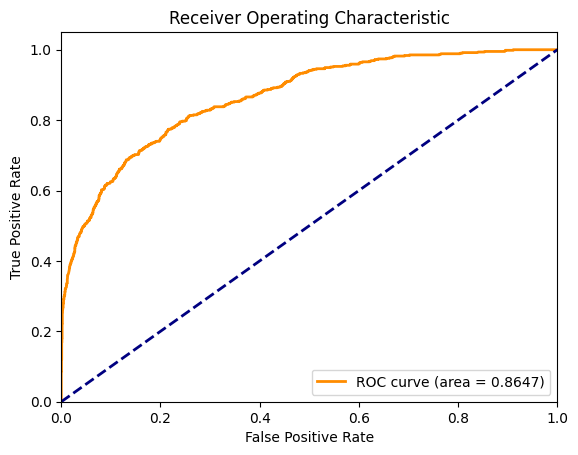

['ada' 'cat' 'rf']
              precision    recall  f1-score   support

           0     0.9028    0.9096    0.9062      2389
           1     0.6358    0.6170    0.6262       611

    accuracy                         0.8500      3000
   macro avg     0.7693    0.7633    0.7662      3000
weighted avg     0.8484    0.8500    0.8492      3000



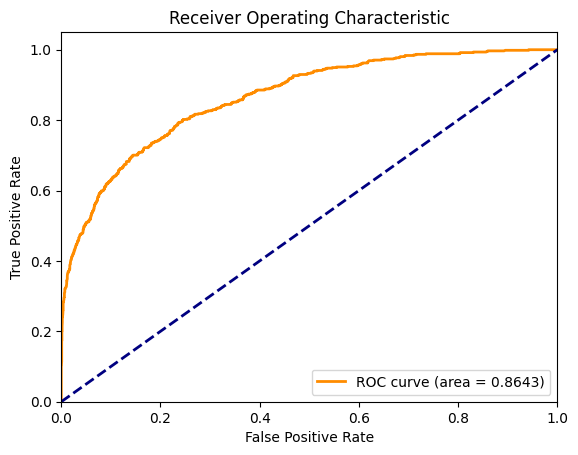

['ada' 'rf' 'cat']
              precision    recall  f1-score   support

           0     0.9029    0.9104    0.9066      2389
           1     0.6379    0.6170    0.6273       611

    accuracy                         0.8507      3000
   macro avg     0.7704    0.7637    0.7670      3000
weighted avg     0.8489    0.8507    0.8497      3000



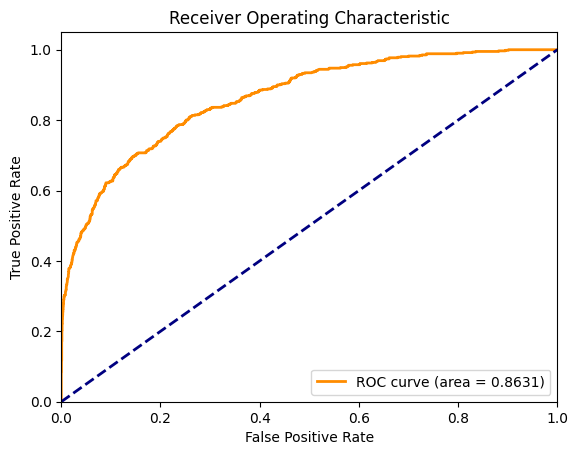

In [71]:
from itertools import permutations
from sklearn.ensemble import StackingClassifier

perms = list(map(list, permutations(estimators)))

for perm in perms:
    stacking = StackingClassifier(estimators=perm, final_estimator=cat, cv=5)

    stacking.fit(X_train, y_train)

    y_pred = stacking.predict(X_test)
    
    print(np.array(perm)[:, 0])
    
    print(classification_report(y_test, y_pred, digits=4))

    auc_plot(stacking, X_test, y_test)